# Matrix Factorization Models

Here we compare the performance of different models of matrix factorization

In [1]:
# Setup
import utils
import matrix_factorization as mf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'
sns.set()
sns.set_style("white")

In [2]:
Y_train = utils.get_training_data()
Y_test = utils.get_test_data()
Y = utils.get_data()
movie_id, movie_title, movie_genre, genres = utils.get_movies()
genre_similarity = utils.genre_similarity(movie_genre)

M = 943 # users
N = 1682 # movies
K = 20
reg = 0.1
eta = 0.03

## 1. Simple SGD from Homework

In [3]:
U_simple, V_simple, err_simple = mf.train_model(Y_train, M, N, K, eta, reg)
err_test_simple = mf.get_err(U_simple, V_simple, Y_test)
err_test_simple /= Y_test.shape[0]
print('Current test error:', '{:.3f}'.format(err_test_simple))

Epoch  0: current average training error 0.502
Epoch  1: current average training error 0.435
Epoch  2: current average training error 0.411
Epoch  3: current average training error 0.393
Epoch  4: current average training error 0.380
Epoch  5: current average training error 0.367
Epoch  6: current average training error 0.359
Epoch  7: current average training error 0.352
Epoch  8: current average training error 0.344
Epoch  9: current average training error 0.336
Epoch 10: current average training error 0.336
Current test error: 0.458


## 2. Incorporating a Bias Term

In [4]:
U_bias, V_bias, biases, err_bias = mf.train_model(Y_train, M, N, K, eta, reg, include_bias=True)
err_test_bias = mf.get_err(U_bias, V_bias, Y_test, biases=biases)
err_test_bias /= Y_test.shape[0]
print('Current test error:', '{:.3f}'.format(err_test_bias))

Epoch  0: current average training error 0.422
Epoch  1: current average training error 0.404
Epoch  2: current average training error 0.394
Epoch  3: current average training error 0.383
Epoch  4: current average training error 0.372
Epoch  5: current average training error 0.361
Epoch  6: current average training error 0.349
Epoch  7: current average training error 0.341
Epoch  8: current average training error 0.332
Epoch  9: current average training error 0.324
Epoch 10: current average training error 0.316
Epoch 11: current average training error 0.310
Epoch 12: current average training error 0.305
Epoch 13: current average training error 0.301
Epoch 14: current average training error 0.296
Epoch 15: current average training error 0.292
Epoch 16: current average training error 0.289
Epoch 17: current average training error 0.285
Epoch 18: current average training error 0.283
Epoch 19: current average training error 0.280
Epoch 20: current average training error 0.278
Epoch 21: cur

## Off-the-shelf solution

In [5]:
import surprise
from surprise import accuracy
from surprise import SVD
from surprise import Reader
from surprise import Dataset

pkf = surprise.model_selection.PredefinedKFold()
reader = Reader(rating_scale=(1, 5))

fulldata = Dataset.load_from_folds([("data/train.txt","data/test.txt")],reader)

surprise_SVD = SVD(n_factors = 20, n_epochs = 30, 
                   lr_all=eta, reg_all=reg, biased = True)

for trainset, testset in pkf.split(fulldata):

    # train and test algorithm.
    surprise_SVD.fit(trainset)
    predictions = surprise_SVD.test(testset)

    # Compute and print Mean Squared Error
    surprise_error = accuracy.rmse(predictions, verbose=True)**2
    

RMSE: 0.9139


In [6]:
err_test_surprise = mf.get_err(surprise_SVD.pu.T, surprise_SVD.qi.T, Y_test, 
                 biases=[surprise_SVD.bu, surprise_SVD.bi, biases[2]])/Y_test.shape[0]
print('Current test error:', '{:.3f}'.format(err_test_surprise))

Current test error: 0.815


In [7]:
accuracies = pd.DataFrame(columns=["Error"])
accuracies = accuracies.append(pd.Series([err_test_simple], name="Simple SVD", index=["Error"]))
accuracies = accuracies.append(pd.Series([err_test_bias], name="Biased SVD", index=["Error"]))
accuracies = accuracies.append(pd.Series([err_test_surprise], name="Surprise", index=["Error"]))
accuracies

,Error
Simple SVD,0.457973
Biased SVD,0.417527
Surprise,0.815088


## Visualization

### Movie projections

In [8]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.layouts import row

def get_SVD_movie_projection(V):
    
     # SVD for the latent factor of the movies
    A, _, _ = np.linalg.svd(V)
    
    V_transformed = np.multiply(A[0:1, :].T, V)
    
    return V_transformed

def get_movie_projection_plot(V, title, size=300):
    
    plot = figure(plot_width=size, plot_height=size, title=title)
    plot.circle(V[0, :], V[1, :])
    plot.xaxis.axis_label = "1"
    plot.yaxis.axis_label = "2"
    plot.toolbar_location = None
    
    return plot

V_simple_transformed = get_SVD_movie_projection(V_simple)
V_bias_transformed = get_SVD_movie_projection(V_bias)
V_surprise_transformed = surprise_SVD.pu[:, 0:2].T

simple_SVD_projection_plot = get_movie_projection_plot(V_simple_transformed, "Simple Movie SVD Projection")
bias_SVD_projection_plot = get_movie_projection_plot(V_bias_transformed, "Biased Movie SVD Projection")
off_the_shelf_projection_plot = get_movie_projection_plot(V_surprise_transformed, "Surprise Movie SVD Projection")
output_notebook()
show(row([simple_SVD_projection_plot, bias_SVD_projection_plot, off_the_shelf_projection_plot]))

Loading BokehJS ...

In [9]:
A, S, B = np.linalg.svd(V_simple) # SVD for the latent factor of the movies
print(A.shape, S.shape, B.shape)
V2 = A.T[:2, :]@V_simple # Project V to 2D
print(V2.shape)

(20, 20) (20,) (1682, 1682)
(2, 1682)


In [10]:
counts, ratings, ratings_bayesian = utils.bayesian_rating(Y_train, thr=4)
rank_counts = np.argsort(-counts) # Indices of counts in descending order
rank_ratings = np.argsort(-ratings) # Indices of ratings in descending order
rank_ratings_bayesian = np.argsort(-ratings_bayesian) # Indices of ratings in descending order
print(ratings[rank_ratings[:5]], counts[rank_ratings[:5]])
print(ratings[rank_ratings_bayesian[:5]], counts[rank_ratings_bayesian[:5]])
print(movie_title[rank_ratings_bayesian[:5]])

[5. 5. 5. 5. 5.] [3 1 1 1 1]
[4.50925926 4.48275862 4.45914397 4.45070423 4.47619048] [108 261 257 213  63]
['"Close Shave, A (1995)"' "Schindler's List (1993)"
 '"Shawshank Redemption, The (1994)"' 'Casablanca (1942)'
 'Wallace & Gromit: The Best of Aardman Animation (1996)']


/Volumes/Thanos/Jialiang/OneDrive - California Institute of Technology/PhD/CS155 ML/Miniproject/project2/utils.py:65: RuntimeWarning: Mean of empty slice
  ratings = np.nanmean(YM, axis=0) # Mean rating of the movies


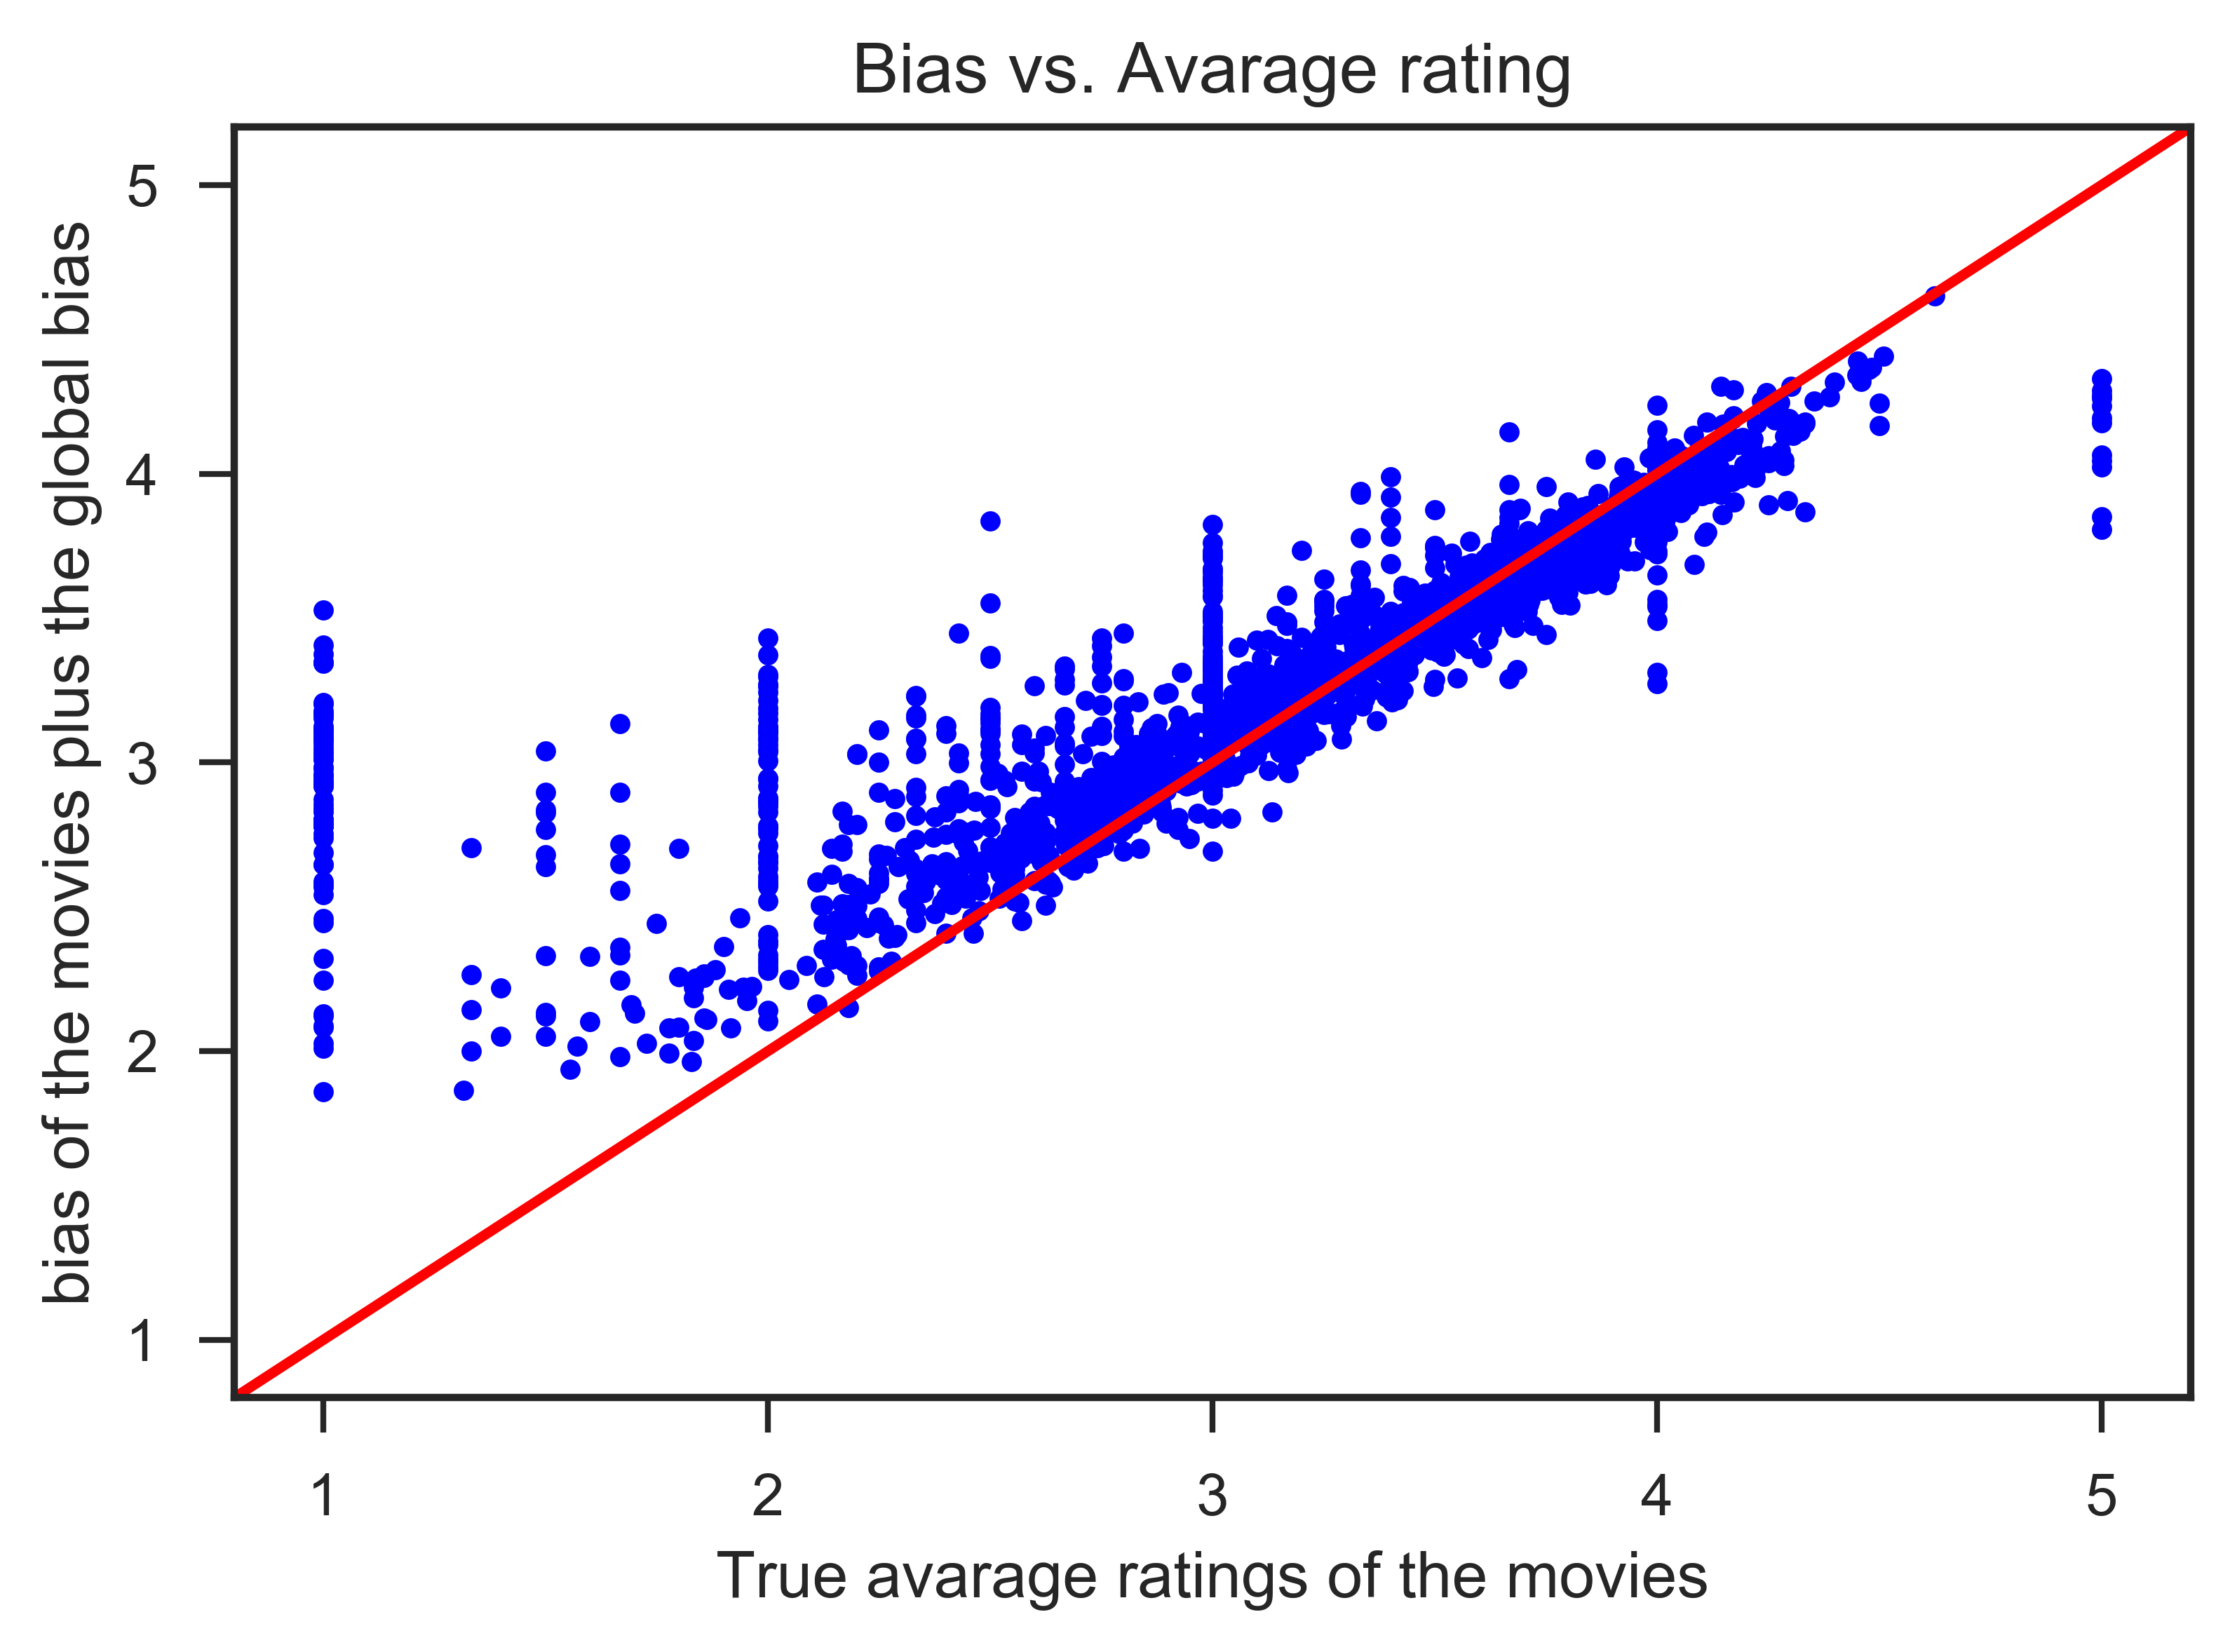

In [11]:
sns.set_style("ticks")
plt.figure(dpi=300)
plt.plot([0, 6], [0, 6], 'r')
plt.scatter(ratings, biases[1]+biases[2], 10, 'b')
plt.xticks(np.arange(1, 6))
plt.yticks(np.arange(1, 6))
plt.xlim(0.8, 5.2)
plt.ylim(0.8, 5.2)
plt.xlabel('True avarage ratings of the movies')
plt.ylabel('bias of the movies plus the global bias')
plt.title('Bias vs. Avarage rating')
plt.show()

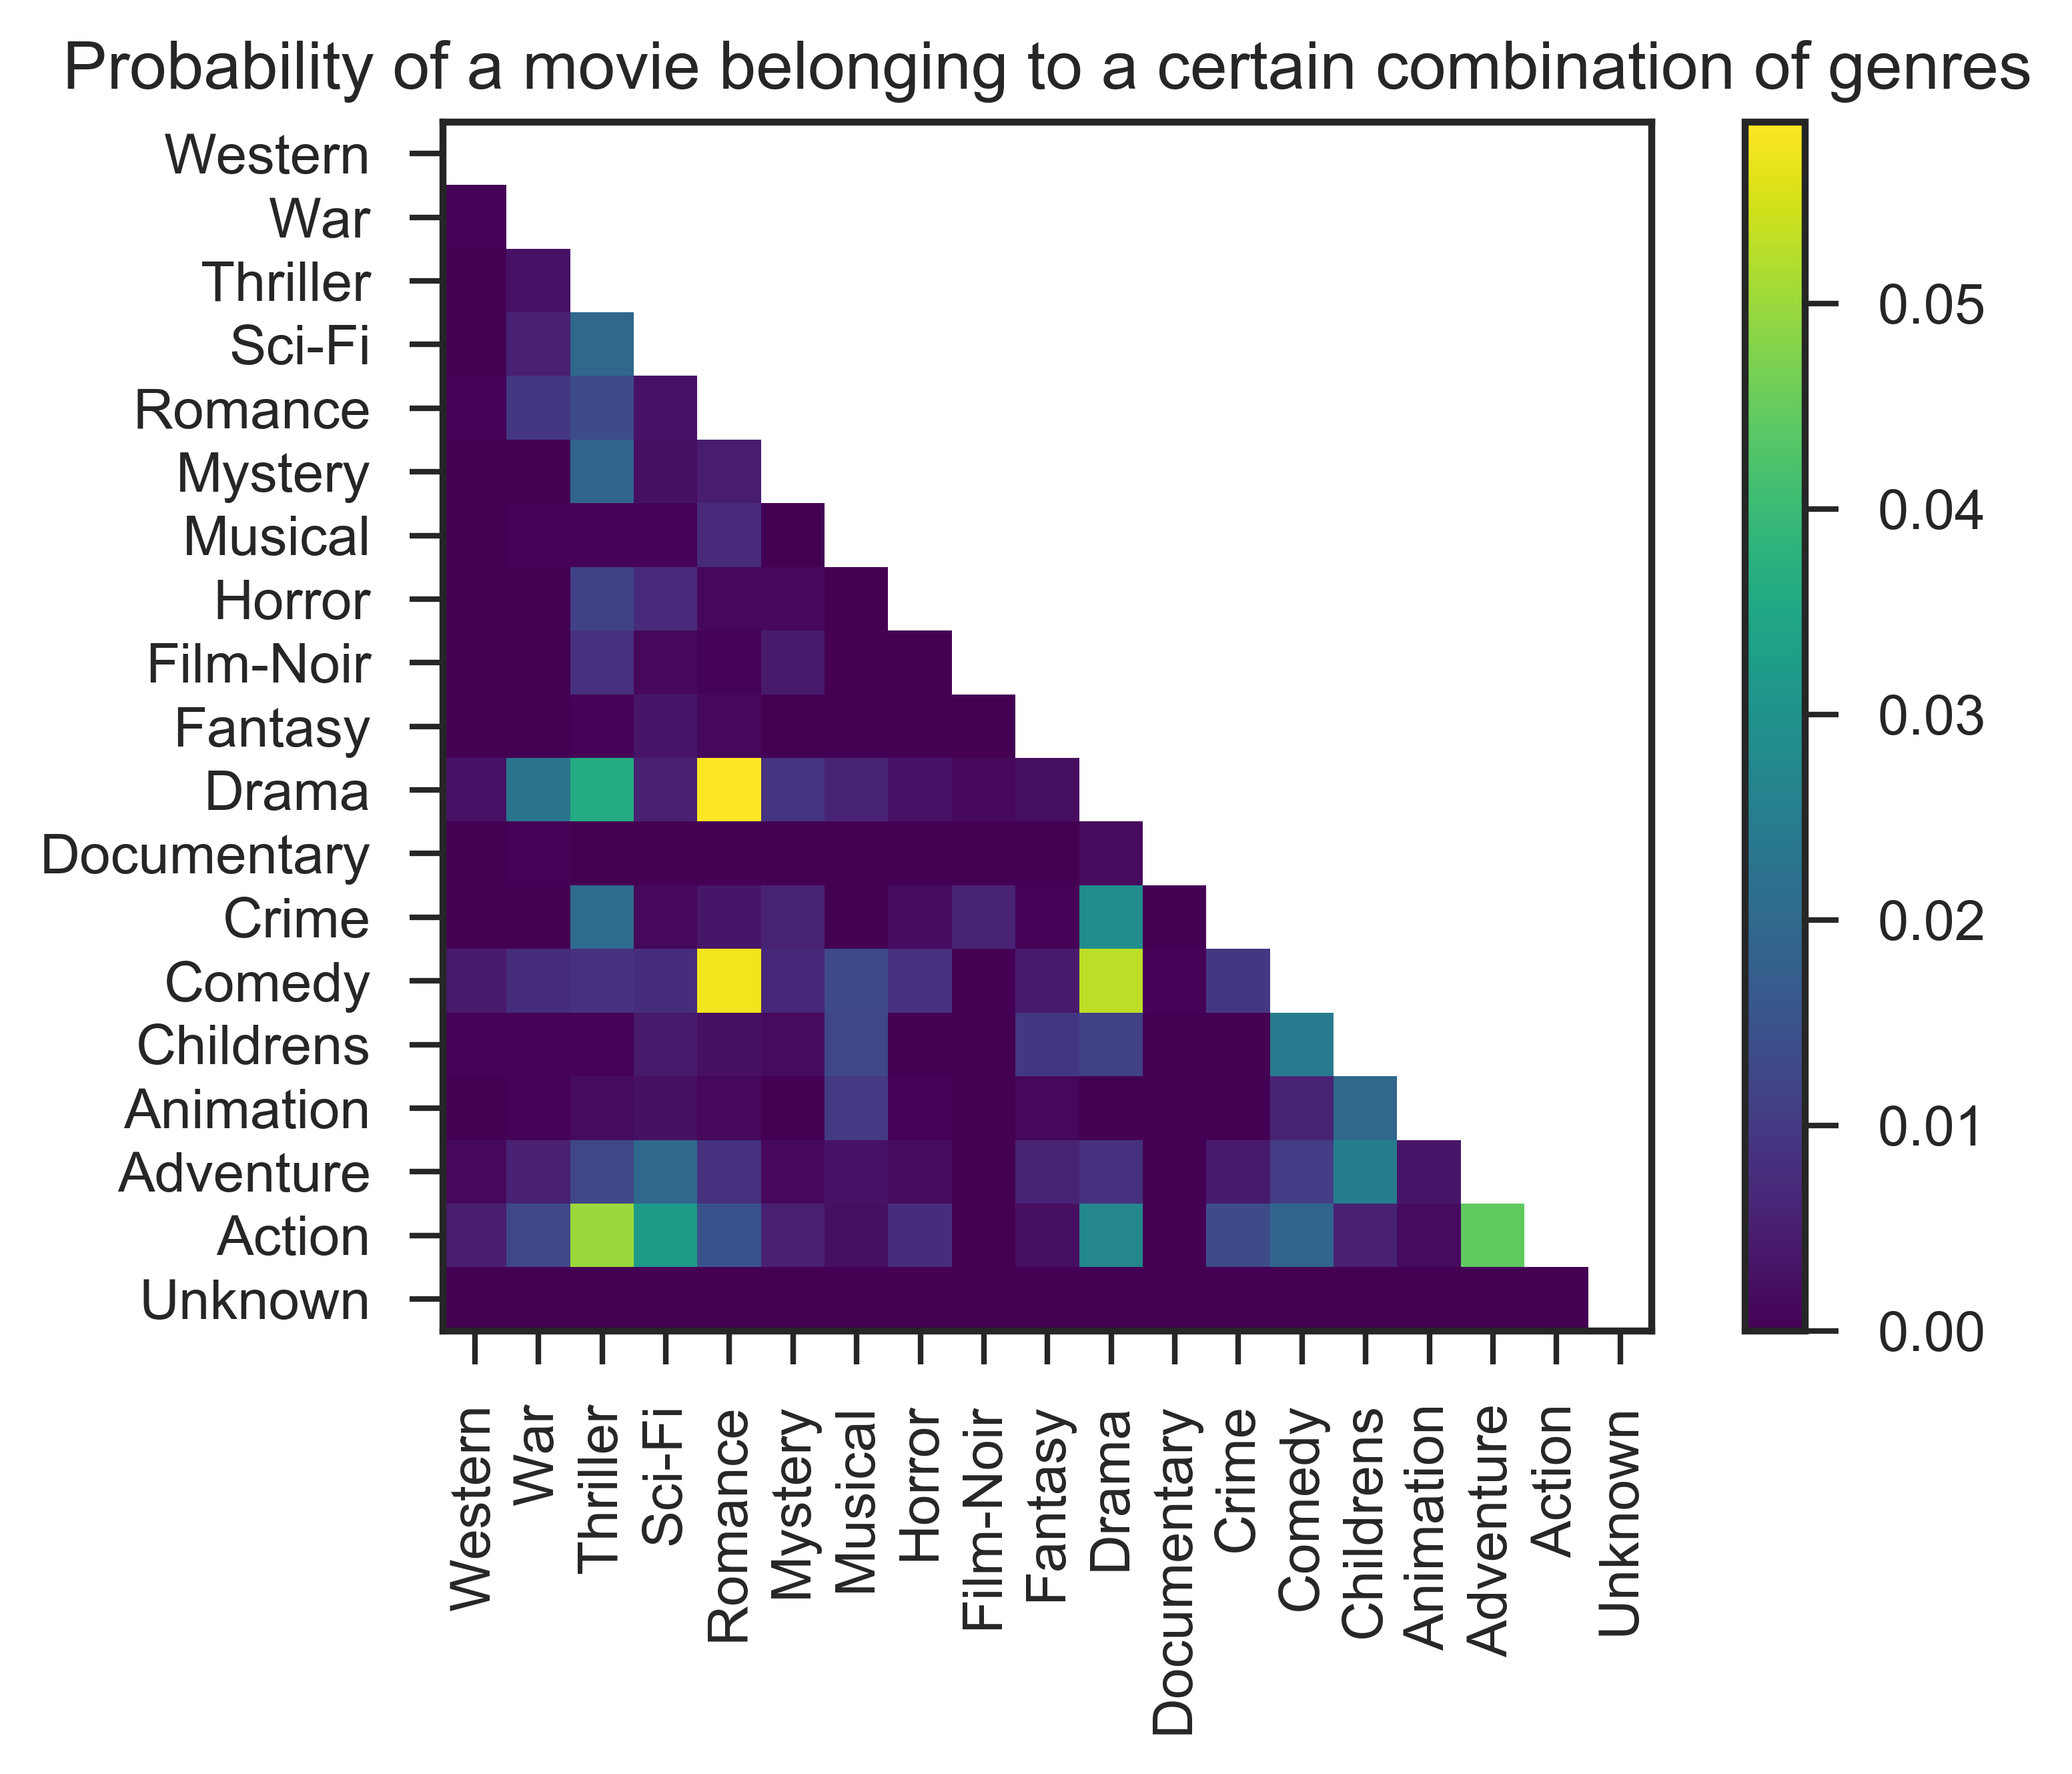

In [12]:
sns.set_style("ticks")
n_genres = len(genres)
genre_similarity_nodiag = genre_similarity.copy()
for i in range(n_genres):
    genre_similarity_nodiag[i, i] = np.nan
plt.figure(dpi=300)
plt.imshow(np.rot90(genre_similarity_nodiag, 2), extent=[0.5, n_genres+0.5, 0.5, n_genres+0.5],
          cmap='viridis')
plt.xticks(np.arange(n_genres)+1, genres[::-1], rotation='vertical')
plt.yticks(np.arange(n_genres)+1, genres)
plt.colorbar()
plt.title('Probability of a movie belonging to a certain combination of genres')
plt.show()

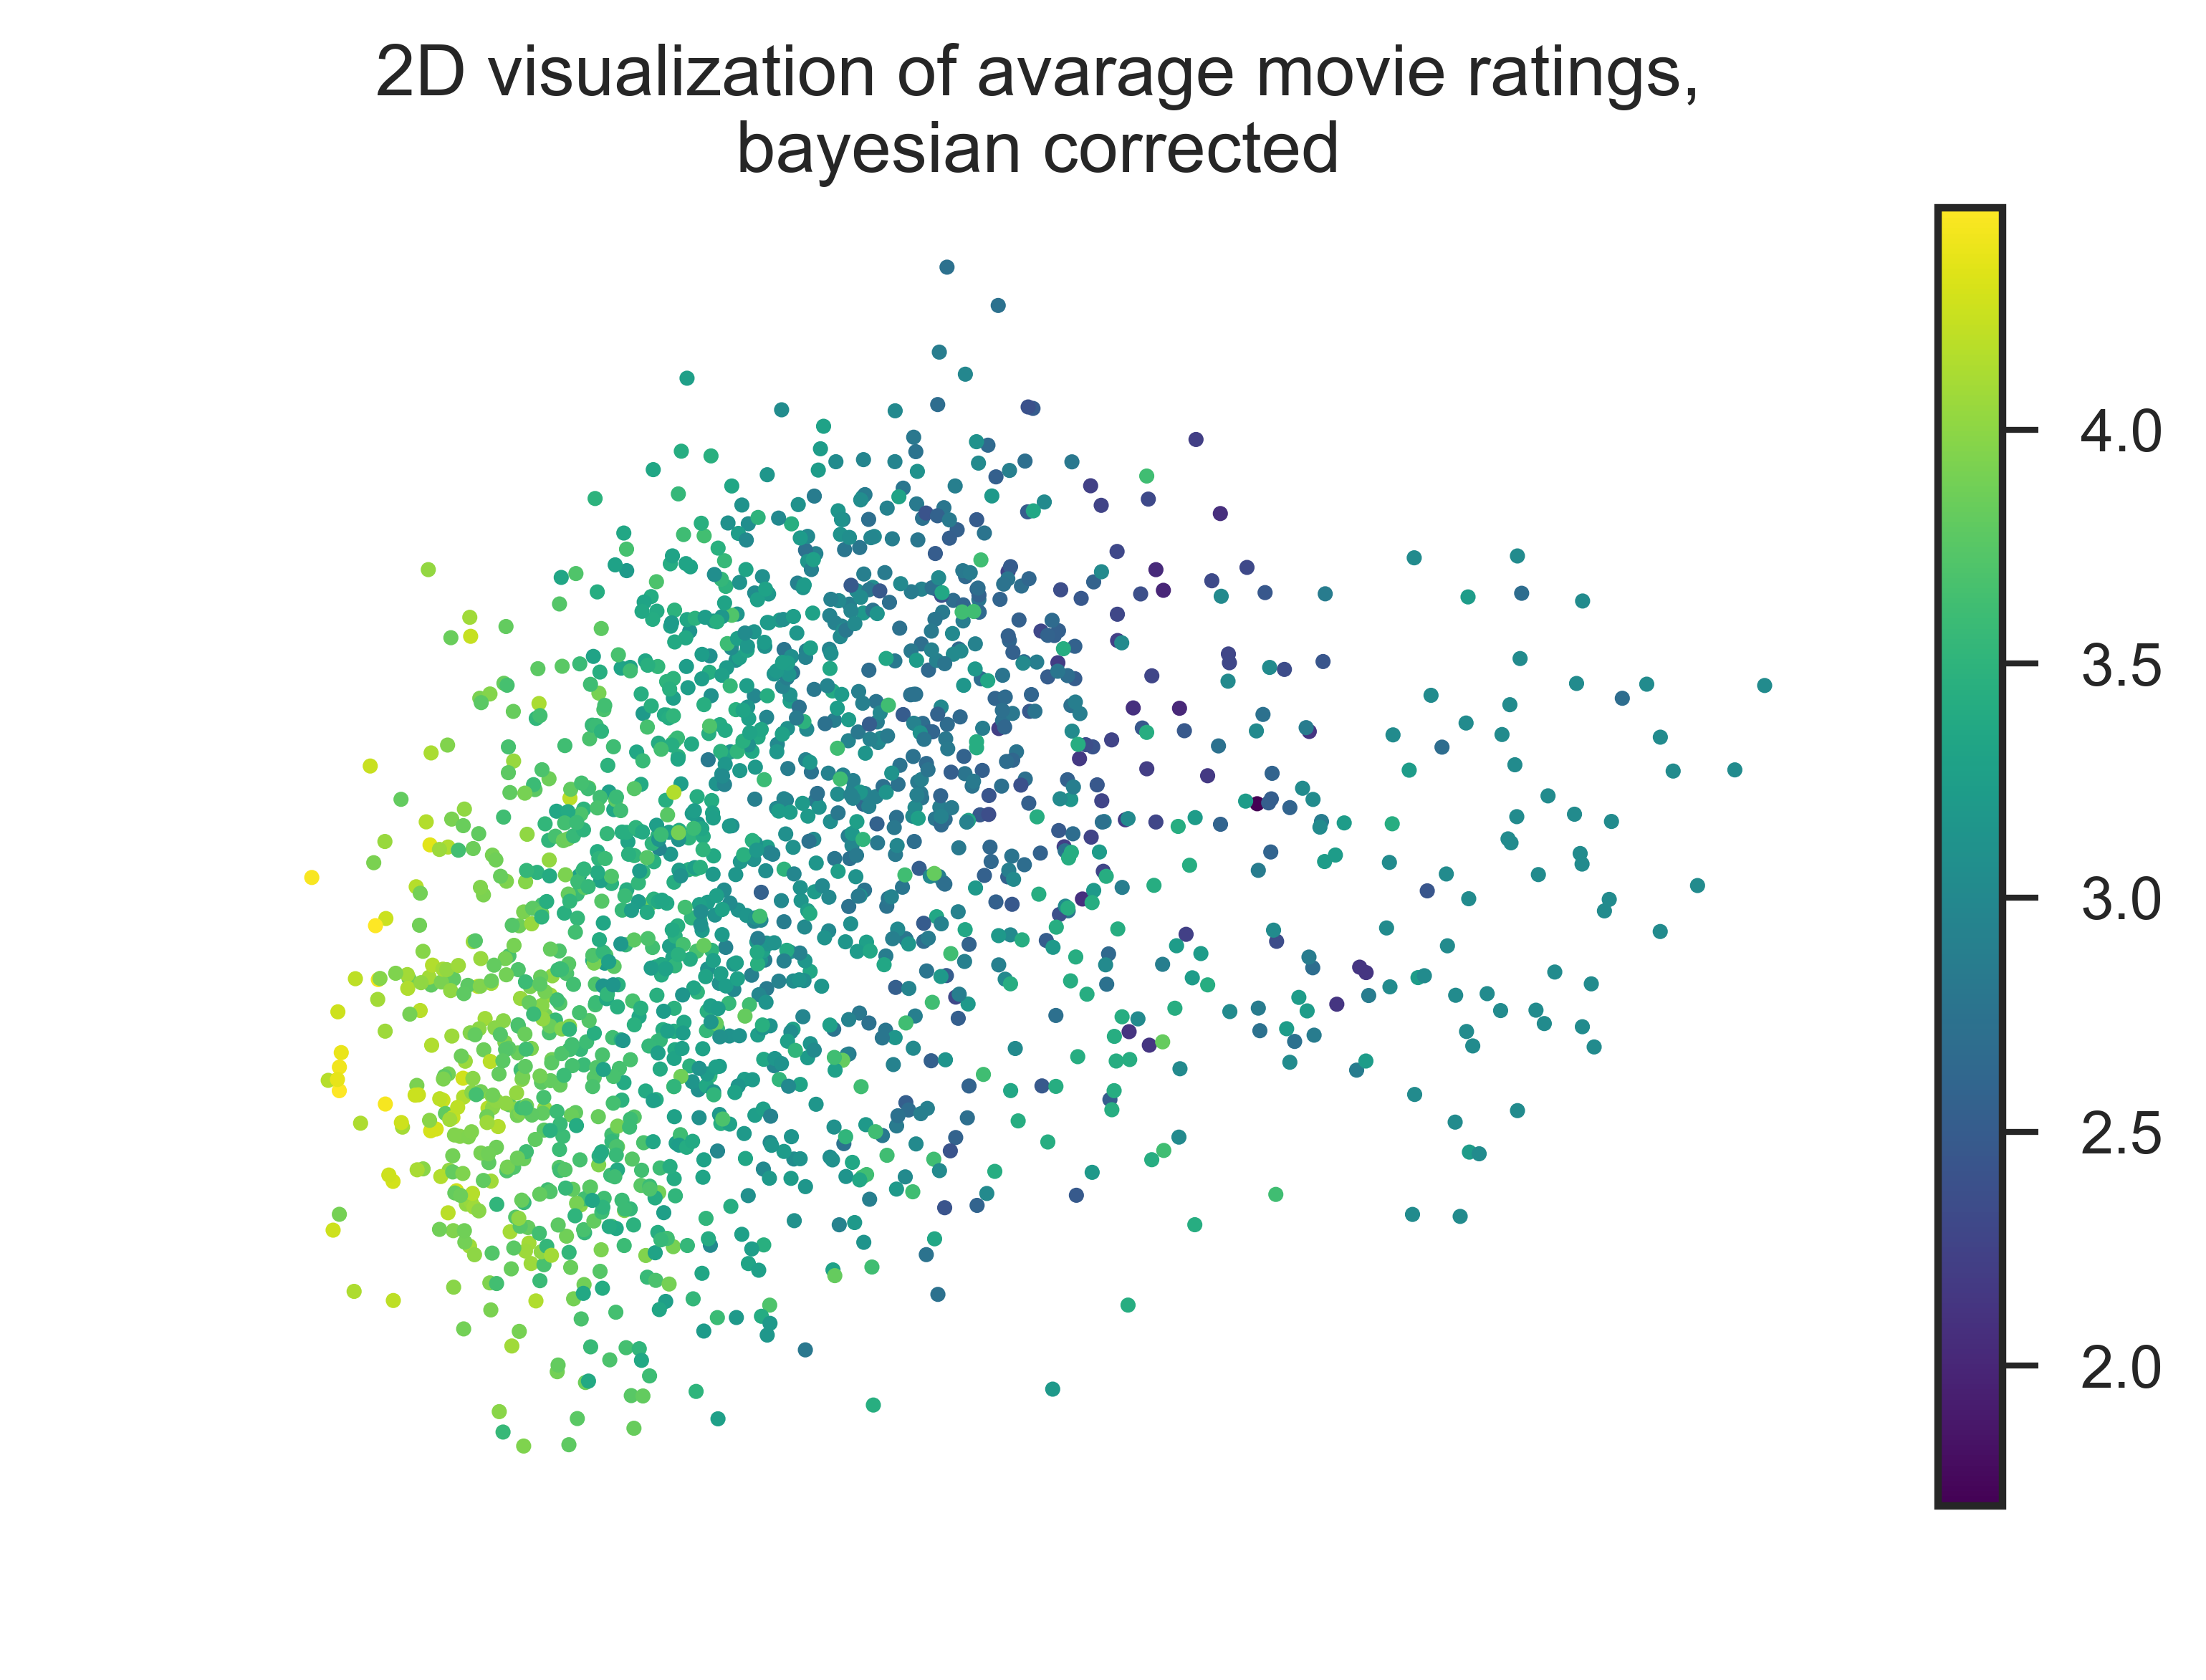

In [13]:
plt.figure(dpi=300)
plt.scatter(V2[0, :], V2[1, :], 5, ratings_bayesian, cmap='viridis')
plt.title('2D visualization of avarage movie ratings,\nbayesian corrected')
plt.colorbar()
plt.axis('off')
plt.show()

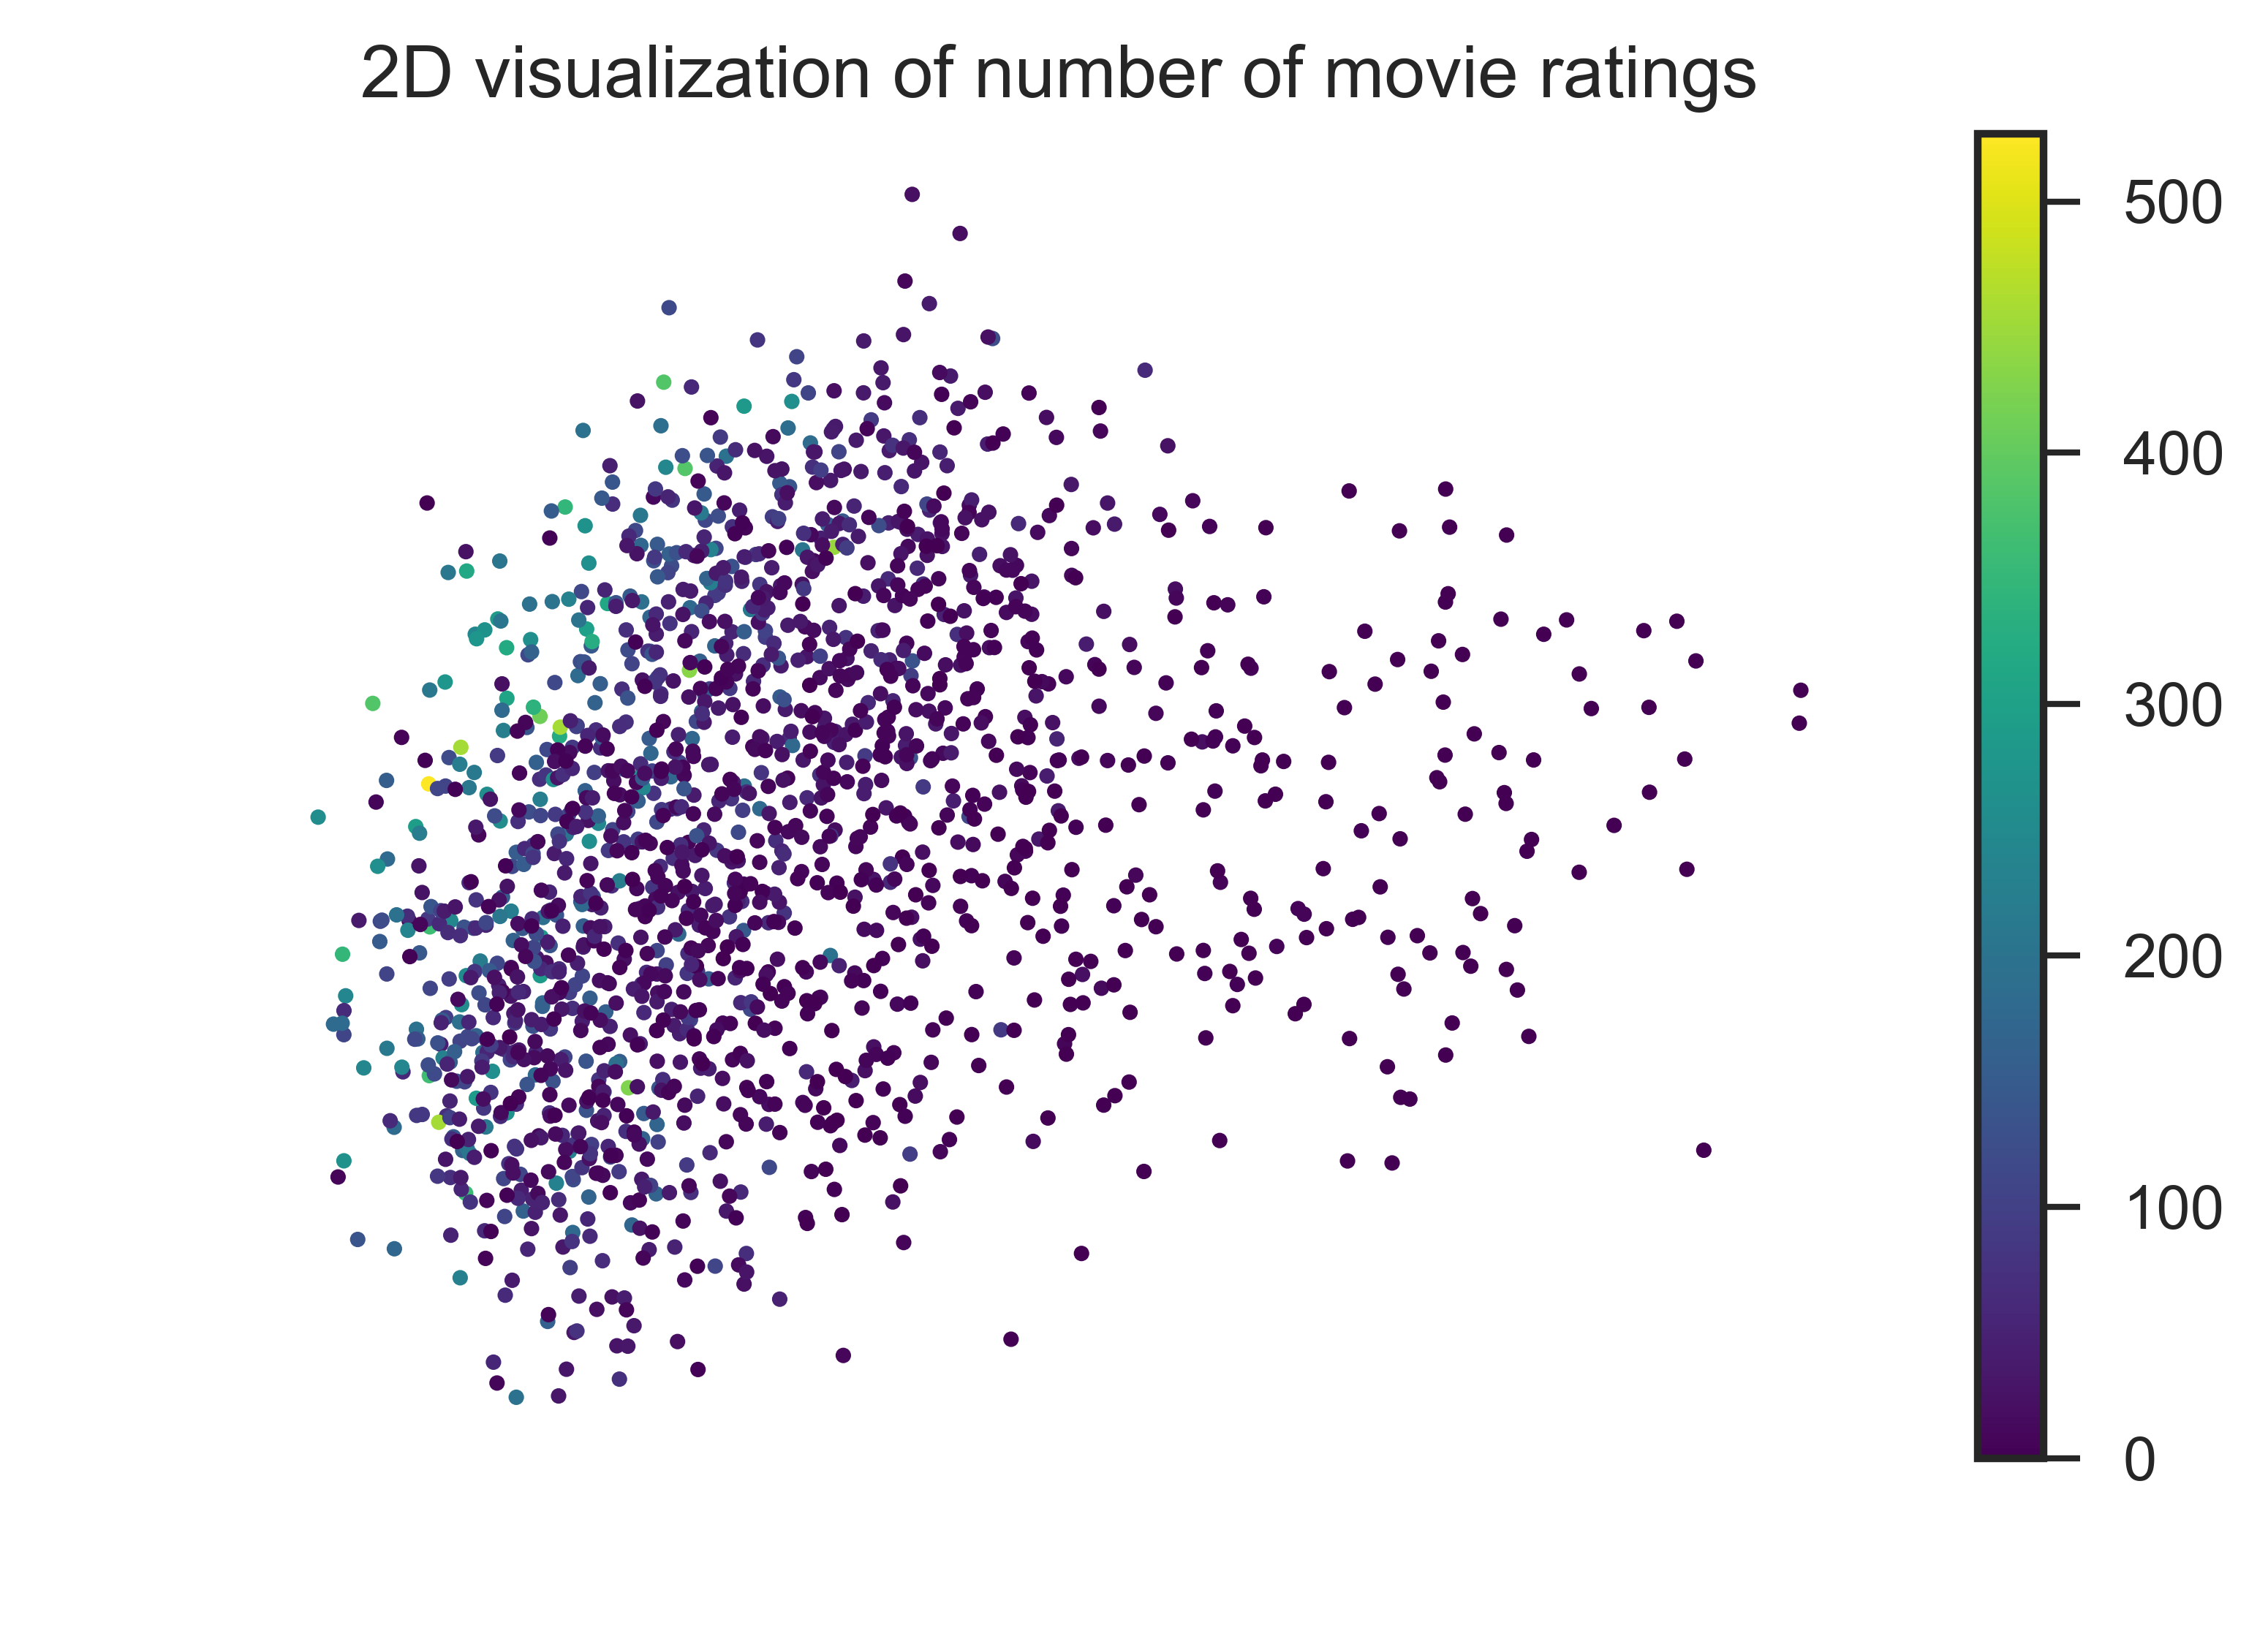

In [14]:
plt.figure(dpi=300)
plt.scatter(V2[0, :], V2[1, :], 5, counts, cmap='viridis')
plt.title('2D visualization of number of movie ratings')
plt.colorbar()
plt.axis('off')
plt.show()

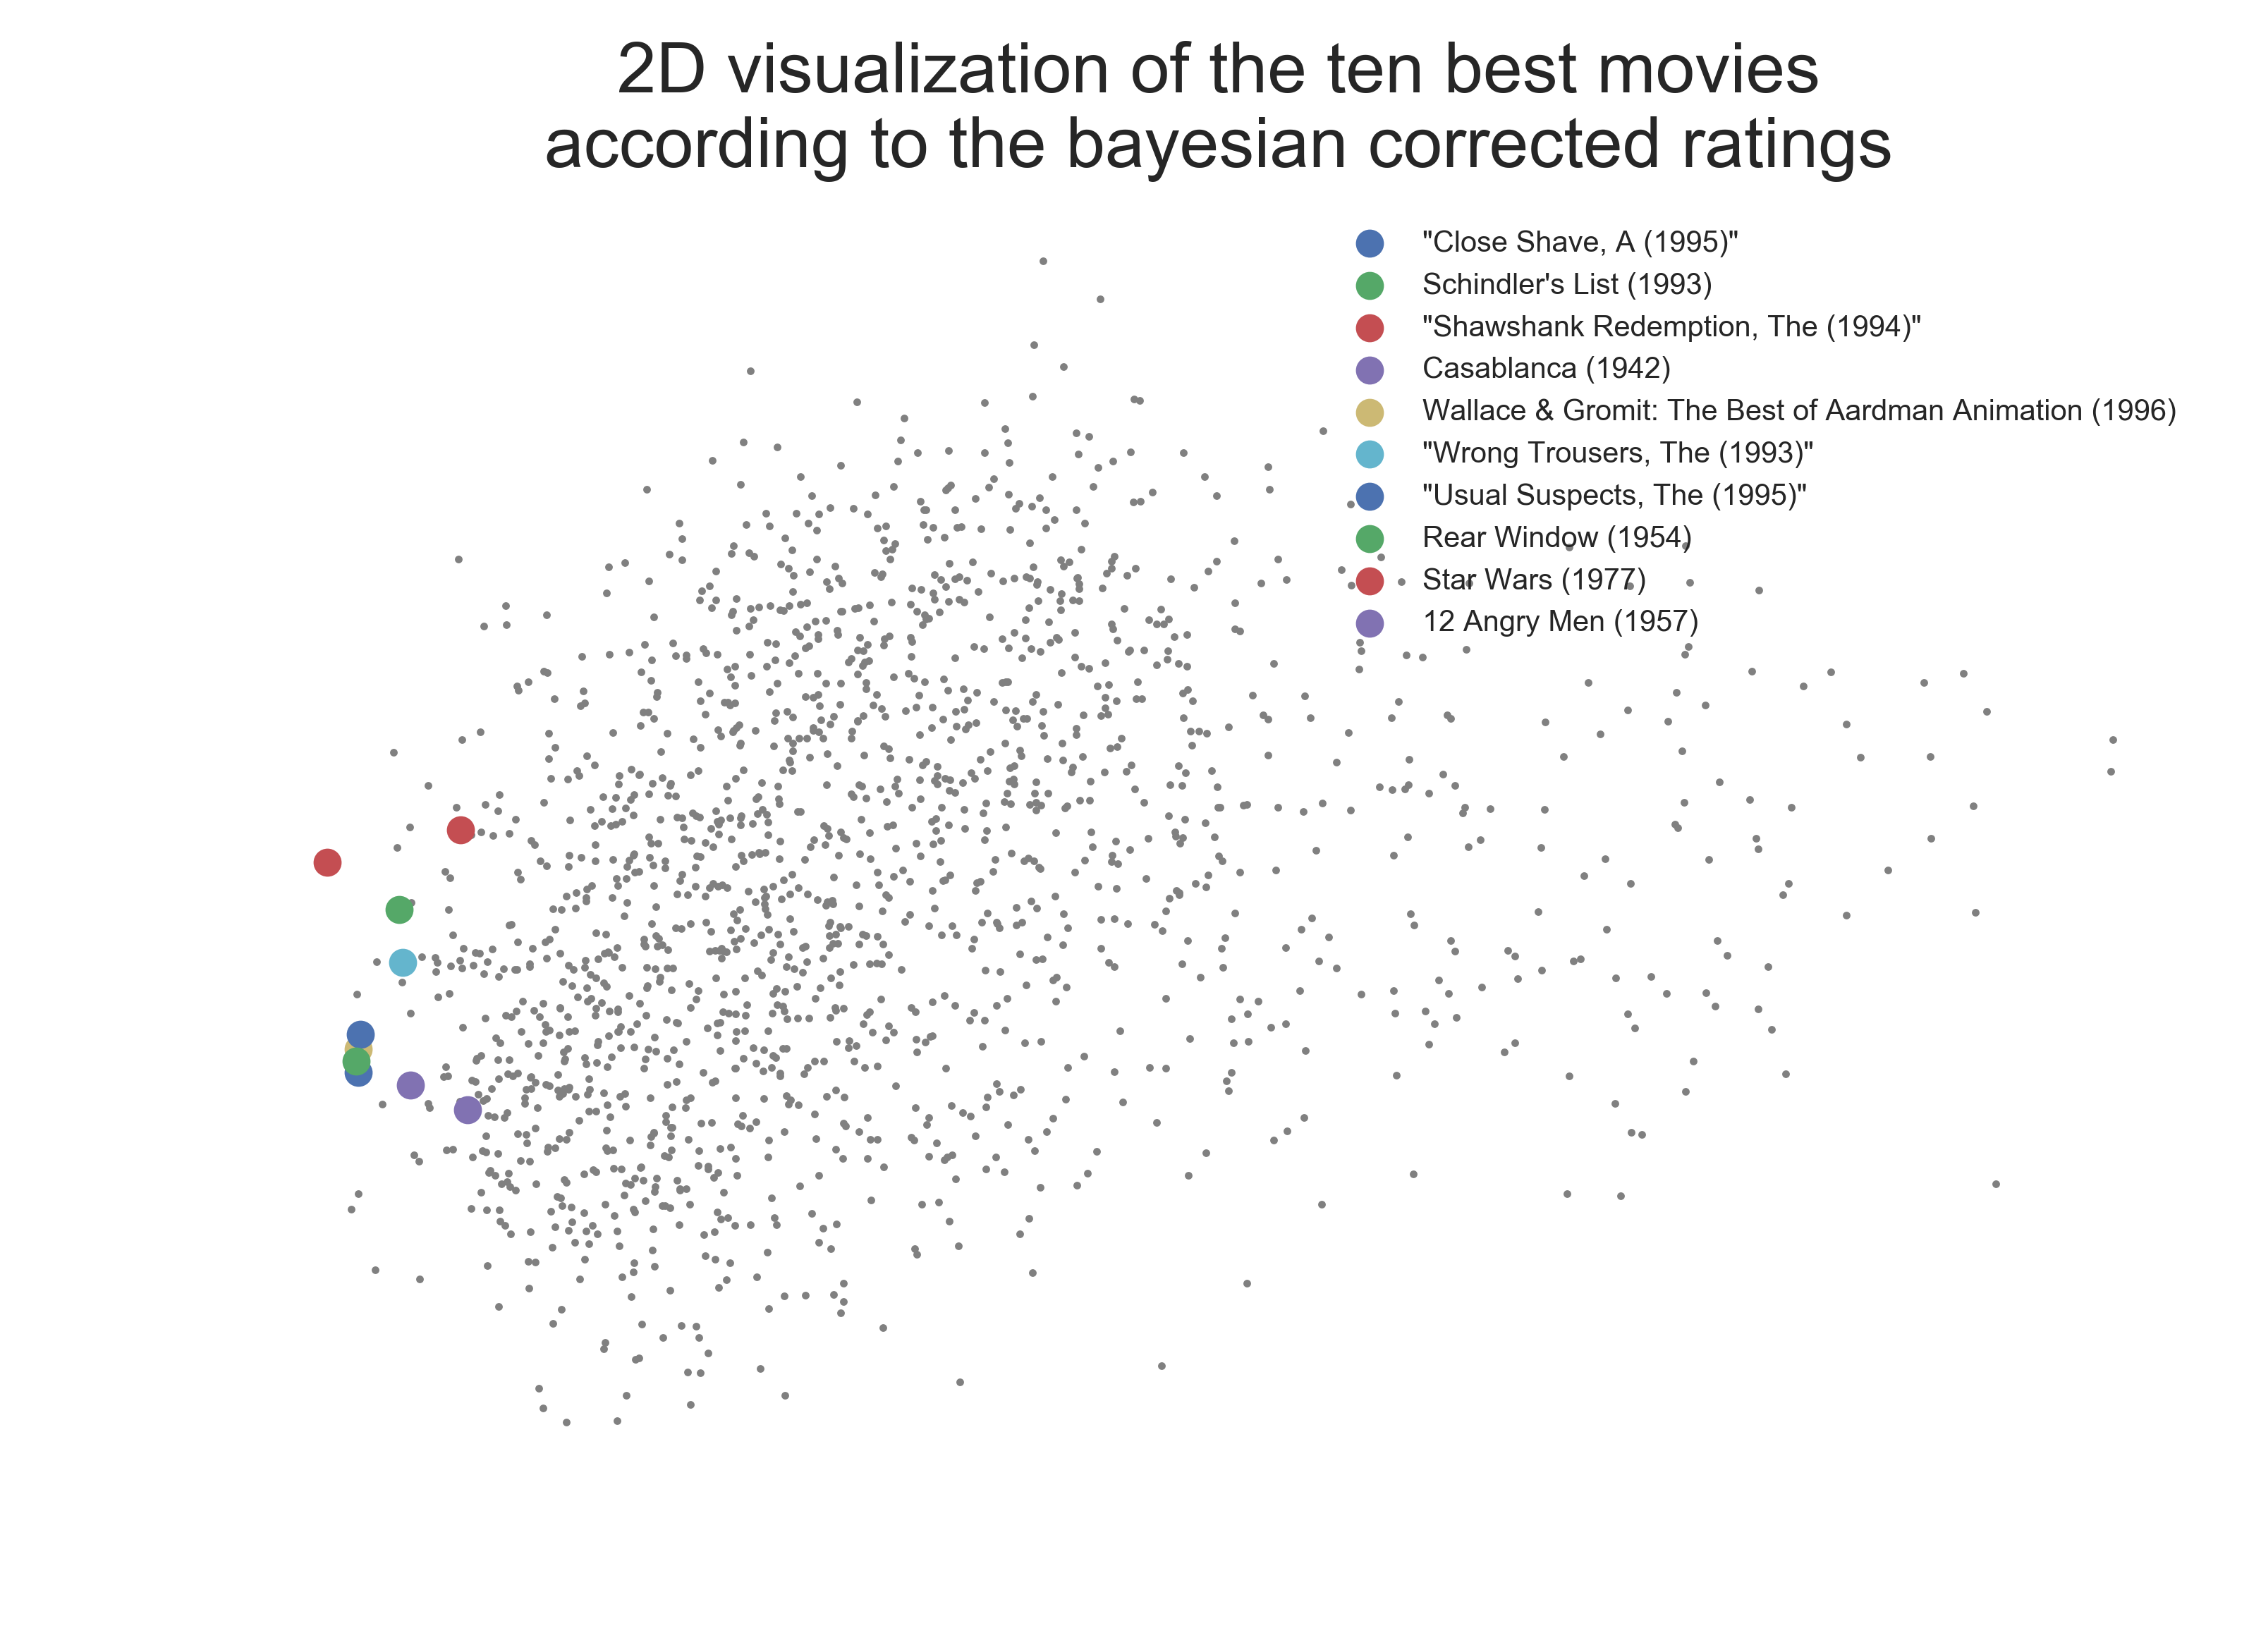

In [15]:
plt.figure(dpi=300)
plt.scatter(V2[0, :], V2[1, :], 1, 'gray')
for idx in rank_ratings_bayesian[:10]:
    plt.scatter(V2[0, idx], V2[1, idx], 20, label=movie_title[idx])
plt.axis('off')
plt.legend(prop={'size': 5})
plt.title('2D visualization of the ten best movies\naccording to the bayesian corrected ratings')
plt.show()

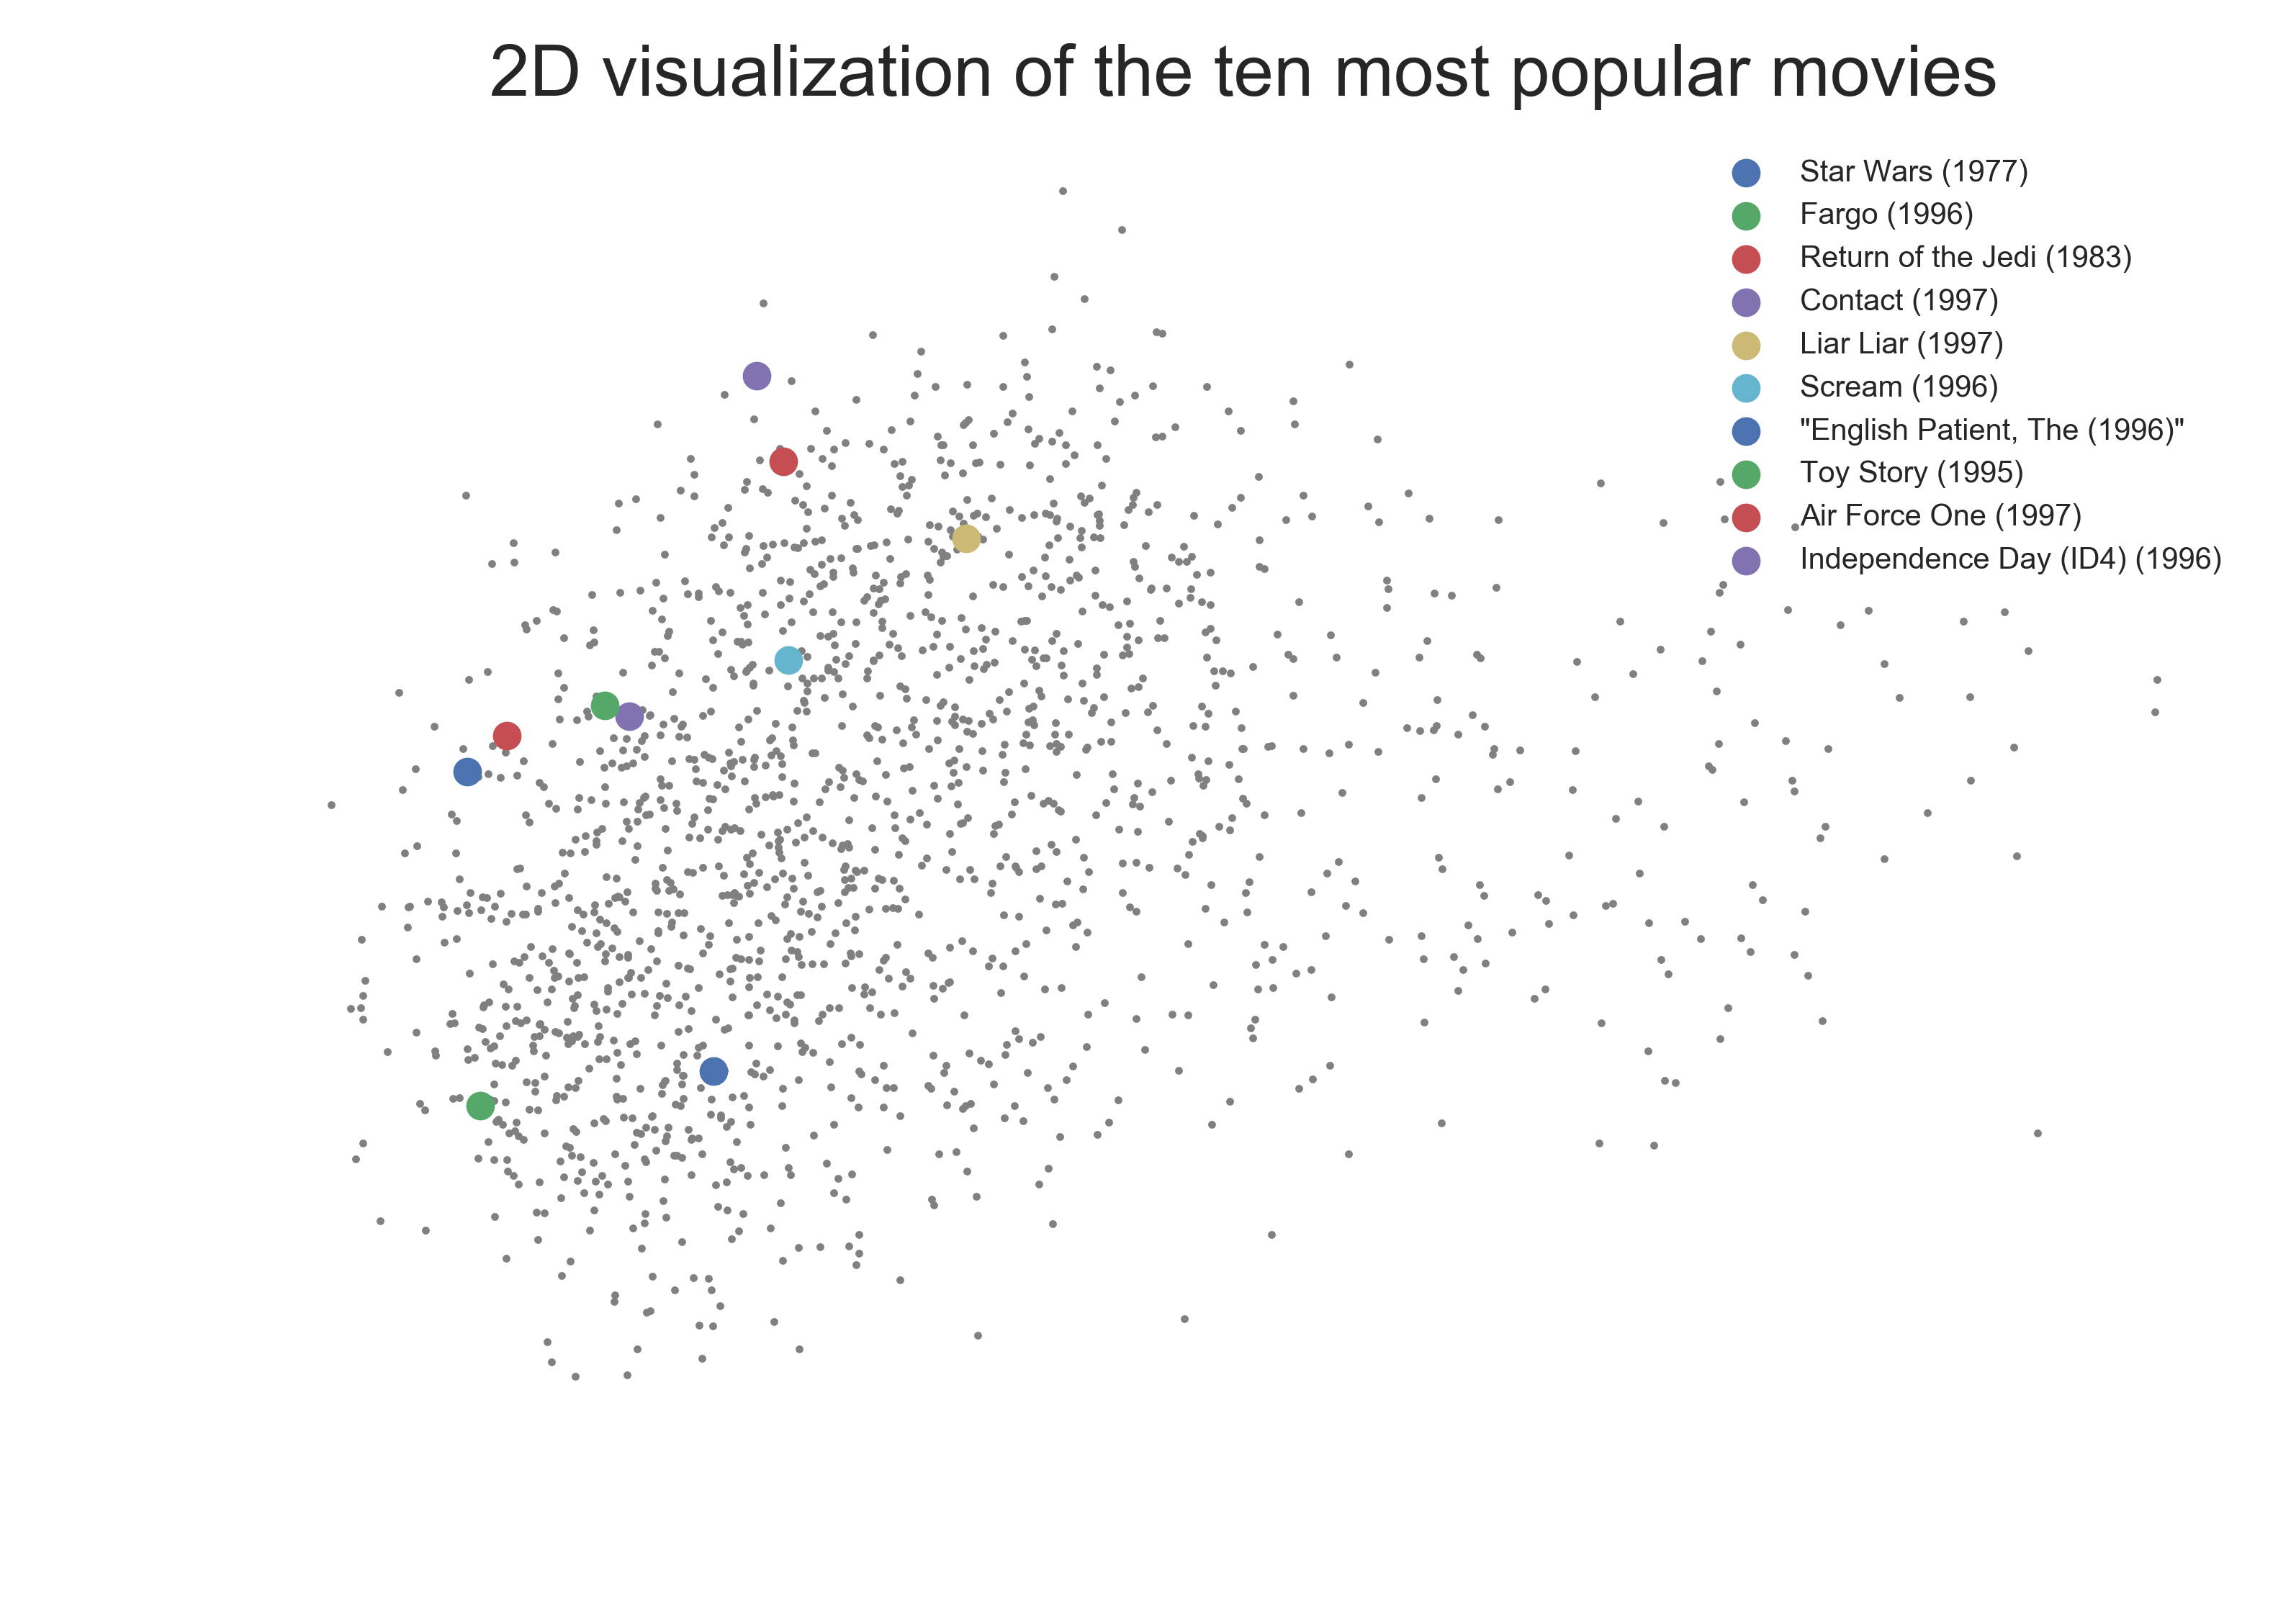

In [16]:
plt.figure(dpi=300)
plt.scatter(V2[0, :], V2[1, :], 1, 'gray')
for idx in rank_counts[:10]:
    plt.scatter(V2[0, idx], V2[1, idx], 20, label=movie_title[idx])
plt.axis('off')
plt.legend(prop={'size': 5})
plt.title('2D visualization of the ten most popular movies')
plt.show()